https://treelite.readthedocs.io/en/latest/index.html

https://mlsys.org/Conferences/doc/2018/196.pdf

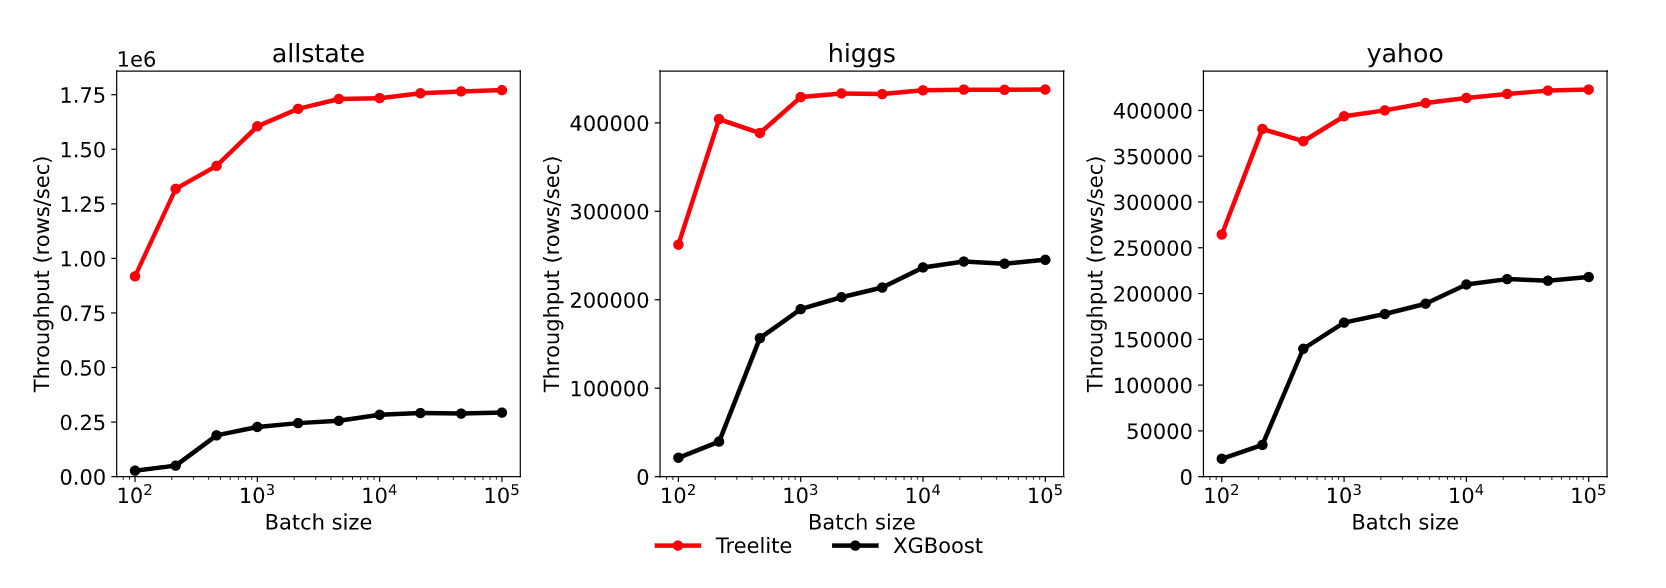

- Host machine : the machine running Treelite.

- Target machine : the machine on which predictions will be made. The host machine may or may not be identical to the target machine. In cases where it’s infeasible to install Treelite on the target machine, the host and target machines will be necessarily distinct.

- Shared library : a blob of executable subroutines that can be imported by other native applications. Shared libraries will often have file extensions .dll, .so, or .dylib. Going back to the particular context of tree deployment, Treelite will produce a shared library containing the prediction subroutine (compiled to native machine code).

- Runtime package : a tiny fraction of the full Treelite package, consisting of a few helper functions that lets you easily load shared libraries and make predictions. The runtime is good to have, but on systems lacking Python we can do without it.

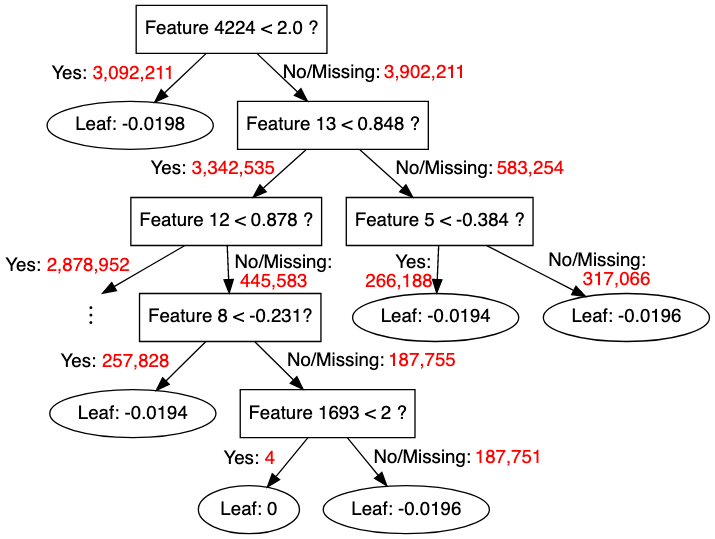

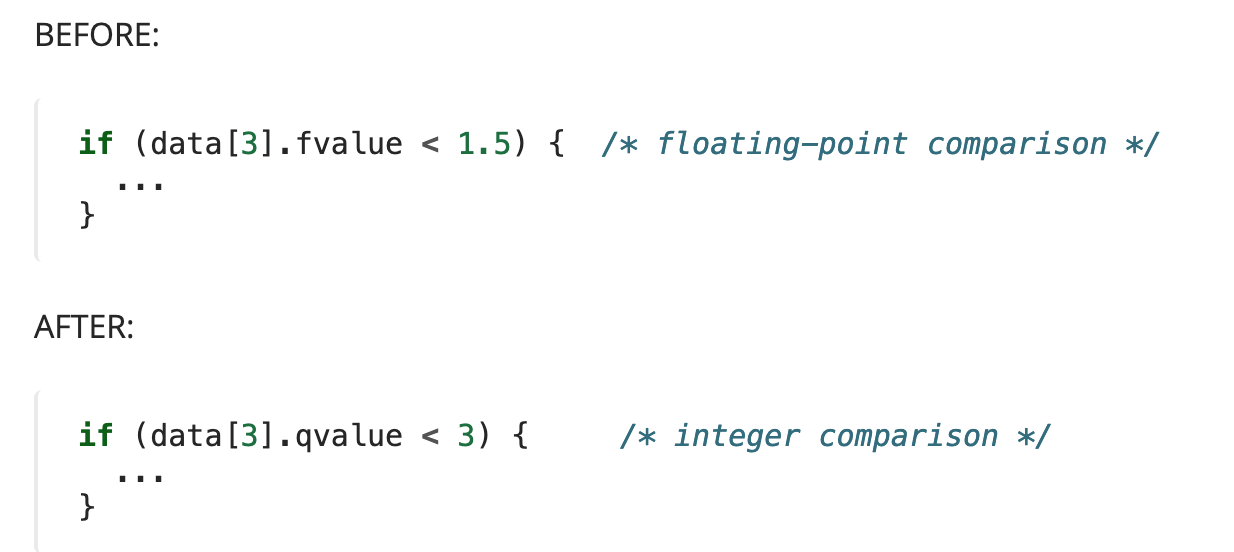

# xgboost

In [1]:
import treelite
import numpy as np
import time

from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100000, n_features=1000)

In [3]:
import xgboost
dtrain = xgboost.DMatrix(X, label=y)
params = {'max_depth':3, 'eta':1, 'objective':'reg:squarederror', 'eval_metric':'rmse'}
bst = xgboost.train(params, dtrain, 20, [(dtrain, 'train')])

[0]	train-rmse:0.21422
[1]	train-rmse:0.20900
[2]	train-rmse:0.20534
[3]	train-rmse:0.20291
[4]	train-rmse:0.20115
[5]	train-rmse:0.19904
[6]	train-rmse:0.19736
[7]	train-rmse:0.19642
[8]	train-rmse:0.19586
[9]	train-rmse:0.19523
[10]	train-rmse:0.19371
[11]	train-rmse:0.19336
[12]	train-rmse:0.19304
[13]	train-rmse:0.19224
[14]	train-rmse:0.19204
[15]	train-rmse:0.19140
[16]	train-rmse:0.19104
[17]	train-rmse:0.19079
[18]	train-rmse:0.19059
[19]	train-rmse:0.19050


In [4]:
model = treelite.Model.from_xgboost(bst)

toolchain = 'gcc'   # change this value as necessary
model.export_lib(toolchain=toolchain, libpath='./mymodel.so', 
                 verbose=True)

import treelite_runtime     # runtime module
predictor = treelite_runtime.Predictor('./mymodel.so', verbose=True)

[00:13:00] /workspace/src/compiler/ast_native.cc:44: Using ASTNativeCompiler
[00:13:00] /workspace/src/compiler/ast/split.cc:24: Parallel compilation disabled; all member trees will be dumped to a single source file. This may increase compilation time and memory usage.
[00:13:00] /workspace/src/c_api/c_api.cc:286: Code generation finished. Writing code to files...
[00:13:00] /workspace/src/c_api/c_api.cc:291: Writing file recipe.json...
[00:13:00] /workspace/src/c_api/c_api.cc:291: Writing file header.h...
[00:13:00] /workspace/src/c_api/c_api.cc:291: Writing file main.c...
[00:13:00] /home/lyz/.local/lib/python3.6/site-packages/treelite/contrib/util.py:104: Compiling sources files in directory ./tmpmf2vqq5a into object files (*.o)...
[00:13:01] /home/lyz/.local/lib/python3.6/site-packages/treelite/contrib/util.py:133: Generating dynamic shared library ./tmpmf2vqq5a/predictor.so...
[00:13:01] /home/lyz/.local/lib/python3.6/site-packages/treelite/contrib/__init__.py:278: Generated share

In [22]:
nrows = [1000, 10000, 100000, 200000]
xgb_time = []
tree_lite = []
for nrow in nrows:
    data = np.random.random((nrow, 1000))
    dtrain = xgboost.DMatrix(data)
    
    start = time.time()
    _ = bst.predict(dtrain)
    xgb_time.append(time.time() - start)
    
    batch = treelite_runtime.Batch.from_npy2d(data)
    
    start = time.time()
    _ = predictor.predict(batch)
    tree_lite.append(time.time() - start)

Populating the interactive namespace from numpy and matplotlib


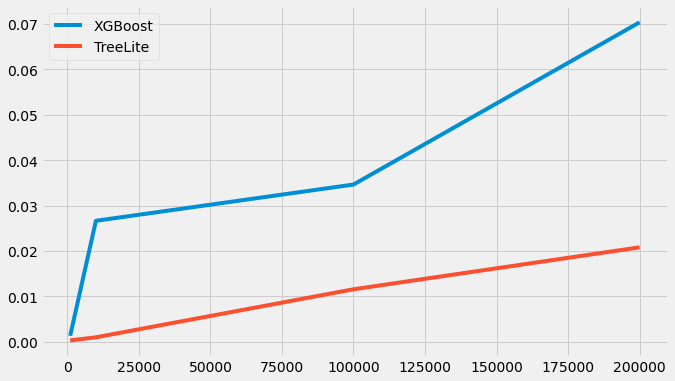

In [23]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))
plt.plot(nrows, xgb_time)
plt.plot(nrows, tree_lite)
plt.legend(['XGBoost', 'TreeLite'])

# LightGBM

In [1]:
import treelite
import numpy as np
import time

from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100000, n_features=1000)

In [2]:
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'max_depth':3,
    'metric': 'binary_logloss',
    'bagging_freq': 5,
    'verbose': 0
}

lgb_train = lgb.Dataset(X, y)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10)

gbm.save_model('model.txt')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.454484 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [3]:
# model = treelite.Model.from_xgboost(bst)
model = treelite.Model.load('model.txt', model_format='lightgbm')

toolchain = 'gcc'   # change this value as necessary
model.export_lib(toolchain=toolchain, libpath='./mymodel.so', verbose=True)

import treelite_runtime     # runtime module
predictor = treelite_runtime.Predictor('./mymodel.so', verbose=True)

[00:17:53] /workspace/src/frontend/lightgbm.cc:544: model.num_tree = 10
[00:17:53] /workspace/src/compiler/ast_native.cc:44: Using ASTNativeCompiler
[00:17:53] /workspace/src/compiler/ast/split.cc:24: Parallel compilation disabled; all member trees will be dumped to a single source file. This may increase compilation time and memory usage.
[00:17:53] /workspace/src/c_api/c_api.cc:286: Code generation finished. Writing code to files...
[00:17:53] /workspace/src/c_api/c_api.cc:291: Writing file recipe.json...
[00:17:53] /workspace/src/c_api/c_api.cc:291: Writing file header.h...
[00:17:53] /workspace/src/c_api/c_api.cc:291: Writing file main.c...
[00:17:53] /home/lyz/.local/lib/python3.6/site-packages/treelite/contrib/util.py:104: Compiling sources files in directory ./tmp4drea_7k into object files (*.o)...
[00:17:54] /home/lyz/.local/lib/python3.6/site-packages/treelite/contrib/util.py:133: Generating dynamic shared library ./tmp4drea_7k/predictor.so...
[00:17:54] /home/lyz/.local/lib/p

In [18]:
nrows = [10000, 50000, 100000, 200000, 500000]
xgb_time = []
tree_lite = []
for nrow in nrows:
    data = np.random.random((nrow, 1000))
    start = time.time()
    _ = gbm.predict(data)
    xgb_time.append(time.time() - start)
    
    batch = treelite_runtime.Batch.from_npy2d(data)
    
    start = time.time()
    _ = predictor.predict(batch)
    tree_lite.append(time.time() - start)

Populating the interactive namespace from numpy and matplotlib


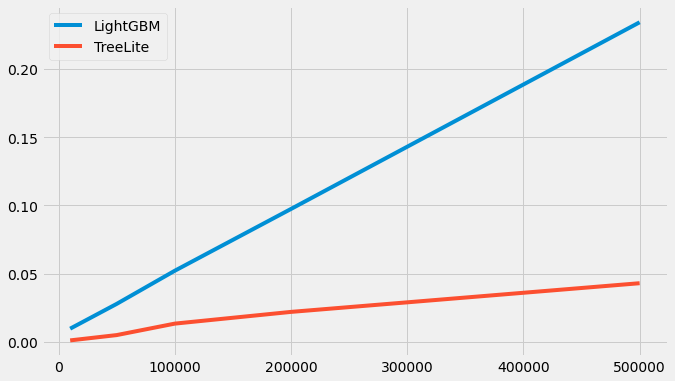

In [19]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))
plt.plot(nrows, xgb_time)
plt.plot(nrows, tree_lite)
plt.legend(['LightGBM', 'TreeLite'])

In [17]:
tree_lite

[0.0010402202606201172,
 0.004858255386352539,
 0.011051416397094727,
 0.020175933837890625,
 0.04127168655395508,
 0.013166666030883789]

# RandomForest

In [1]:
import treelite
import numpy as np
import time

from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100000, n_features=1000)

In [3]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1).fit(X, y)

In [4]:
# model = treelite.Model.from_xgboost(bst)
model = treelite.sklearn.import_model(rf)

toolchain = 'gcc'   # change this value as necessary
model.export_lib(toolchain=toolchain, libpath='./mymodel.so', verbose=True)

import treelite_runtime     # runtime module
predictor = treelite_runtime.Predictor('./mymodel.so', verbose=True)

[00:22:46] /workspace/src/compiler/ast_native.cc:44: Using ASTNativeCompiler
[00:22:46] /workspace/src/compiler/ast/split.cc:24: Parallel compilation disabled; all member trees will be dumped to a single source file. This may increase compilation time and memory usage.
[00:22:46] /workspace/src/c_api/c_api.cc:286: Code generation finished. Writing code to files...
[00:22:46] /workspace/src/c_api/c_api.cc:291: Writing file recipe.json...
[00:22:46] /workspace/src/c_api/c_api.cc:291: Writing file header.h...
[00:22:46] /workspace/src/c_api/c_api.cc:291: Writing file main.c...
[00:22:46] /home/lyz/.local/lib/python3.6/site-packages/treelite/contrib/__init__.py:263: WARNING: some of the source files are long. Expect long compilation time. You may want to adjust the parameter parallel_comp.

[00:22:46] /home/lyz/.local/lib/python3.6/site-packages/treelite/contrib/util.py:104: Compiling sources files in directory ./tmpgq202soq into object files (*.o)...
[00:22:56] /home/lyz/.local/lib/python

In [5]:
nrows = [10000, 50000, 100000, 200000, 500000]
xgb_time = []
tree_lite = []
for nrow in nrows:
    data = np.random.random((nrow, 1000))
    start = time.time()
    _ = rf.predict(data)
    xgb_time.append(time.time() - start)
    
    batch = treelite_runtime.Batch.from_npy2d(data)
    
    start = time.time()
    _ = predictor.predict(batch)
    tree_lite.append(time.time() - start)

Populating the interactive namespace from numpy and matplotlib


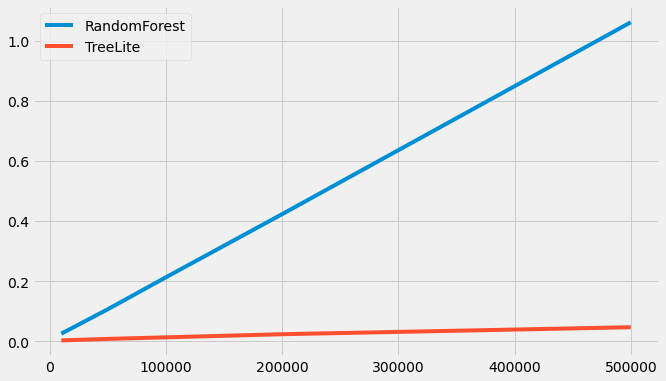

In [6]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))
plt.plot(nrows, xgb_time)
plt.plot(nrows, tree_lite)
plt.legend(['RandomForest', 'TreeLite'])